# SMER Visual Module Demonstration

This notebook demonstrates the functionality of the `smer_visual.py` module, which provides tools for generating image descriptions, embeddings, and analyzing feature importance using logistic regression. This notebook features an example from ImageNet datasets containing hotpots and vases. 


---

## 1. Setup

First, we import the necessary libraries and set up the environment.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from smer_visual import (
    image_description,
    get_description_embeddings,
    classify_with_logreg,
    plot_important_words,
    plot_aopc,
    aggregate_embeddings
)

# Set paths and parameters
data_folder = "data"
model_path = "sentence-transformers/all-MiniLM-L6-v2"
api_key = "your_openai_api_key"  # Replace with your OpenAI API key
embedding_model = "text-embedding-ada-002"
user_prompt = "Describe this image in 7 words."

---

## 2. Generate Image Descriptions

We use the `image_description` function to generate descriptions for images in the specified folder.

In [ ]:
# Generate descriptions using a local model
results = image_description(model="unsloth/Llama-3.2-11B-Vision-Instruct", data_folder="data") 

In [ ]:
# Alternatively, generate descriptions using OpenAI API
results = image_description(model='gpt-4o-mini', data_folder=data_folder, api_key=api_key, user_prompt=user_prompt)

In [ ]:
results

---

## 3. Generate Embeddings for Descriptions

Next, we generate embeddings for the descriptions using the `get_description_embeddings` function.

In [5]:
# Generate embeddings for the descriptions locally
df_embeddings = get_description_embeddings(results, embedding_model = "sentence-transformers/all-MiniLM-L6-v2")

# Display the embeddings DataFrame
print(df_embeddings.head())

                          image  \
0  data/vase/n04522168_494.JPEG   
1  data/vase/n04522168_123.JPEG   
2  data/vase/n04522168_529.JPEG   
3  data/vase/n04522168_154.JPEG   
4  data/vase/n04522168_483.JPEG   

                                         description  \
0  The image features a white ceramic vase with a...   
1          A small vase with a brown and white base.   
2  Vase, plant, and tablecloth in a neutral setting.   
3  An Egyptian vase with intricate blue and gold ...   
4  This image depicts a decorative glass vessel w...   

                                           embedding label  
0  [[-0.19027631, -0.02671379, -0.08945237, 0.149...  vase  
1  [[-0.16147648, -0.076564945, -0.04694235, 0.21...  vase  
2  [[0.07117223, 0.045965582, 0.53020465, -0.5969...  vase  
3  [[-0.15673307, -0.030315764, -0.030138489, 0.2...  vase  
4  [[-0.17709596, 0.093381755, -0.056477163, -0.0...  vase  


In [6]:
# Generate embeddings using OpenAI API
df_embeddings = get_description_embeddings(results, embedding_model=embedding_model, api_key=api_key)

---

## 4. Train Logistic Regression Model

We train a logistic regression model using the embeddings.

In [7]:
# aggregate embeddings by averaging
df_embeddings['aggregated_embedding'] = df_embeddings['embedding'].apply(aggregate_embeddings)
df_embeddings.head()

,image,description,embedding,label,aggregated_embedding
0,data/vase/n04522168_494.JPEG,The image features a white ceramic vase with a...,"[[-0.19027631, -0.02671379, -0.08945237, 0.149...",vase,"[-0.025018679, 0.008164115, 0.07187453, -0.016..."
1,data/vase/n04522168_123.JPEG,A small vase with a brown and white base.,"[[-0.16147648, -0.076564945, -0.04694235, 0.21...",vase,"[0.042978186, -0.013171048, 0.12225657, 0.0060..."
2,data/vase/n04522168_529.JPEG,"Vase, plant, and tablecloth in a neutral setting.","[[0.07117223, 0.045965582, 0.53020465, -0.5969...",vase,"[-0.14304063, 0.0024834308, 0.08901219, -0.048..."
3,data/vase/n04522168_154.JPEG,An Egyptian vase with intricate blue and gold ...,"[[-0.15673307, -0.030315764, -0.030138489, 0.2...",vase,"[-0.1321521, 0.025873346, 0.15727355, -0.04383..."
4,data/vase/n04522168_483.JPEG,This image depicts a decorative glass vessel w...,"[[-0.17709596, 0.093381755, -0.056477163, -0.0...",vase,"[-0.04232358, -0.0003866429, 0.056319956, 0.03..."


In [8]:
X = np.stack(df_embeddings['aggregated_embedding'].values)
y = df_embeddings['label']
logreg_model = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
logreg_model.fit(X_train, y_train)

LogisticRegression()

In [9]:
from sklearn.metrics import accuracy_score
y_pred = logreg_model.predict(X_test)
print(accuracy_score(y_test, y_pred))

1.0


---

## 5. Analyze Feature Importance

Using the `classify_with_logreg` function, we analyze the importance of individual words in the descriptions.

In [10]:
# Analyze feature importance
aopc_df, updated_dataset = classify_with_logreg(
    dataset=df_embeddings,
    X_train=X_train,
    logreg_model=logreg_model
)

# Display the updated dataset
print(updated_dataset.head())

                          image  \
0  data/vase/n04522168_494.JPEG   
1  data/vase/n04522168_123.JPEG   
2  data/vase/n04522168_529.JPEG   
3  data/vase/n04522168_154.JPEG   
4  data/vase/n04522168_483.JPEG   

                                         description  \
0  The image features a white ceramic vase with a...   
1          A small vase with a brown and white base.   
2  Vase, plant, and tablecloth in a neutral setting.   
3  An Egyptian vase with intricate blue and gold ...   
4  This image depicts a decorative glass vessel w...   

                                           embedding label  \
0  [[-0.19027631, -0.02671379, -0.08945237, 0.149...  vase   
1  [[-0.16147648, -0.076564945, -0.04694235, 0.21...  vase   
2  [[0.07117223, 0.045965582, 0.53020465, -0.5969...  vase   
3  [[-0.15673307, -0.030315764, -0.030138489, 0.2...  vase   
4  [[-0.17709596, 0.093381755, -0.056477163, -0.0...  vase   

                                aggregated_embedding  \
0  [-0.025018679, 0.008

---

## 6. Visualize Important Words

We use the `plot_important_words` function to visualize the top 10 most important words across images.

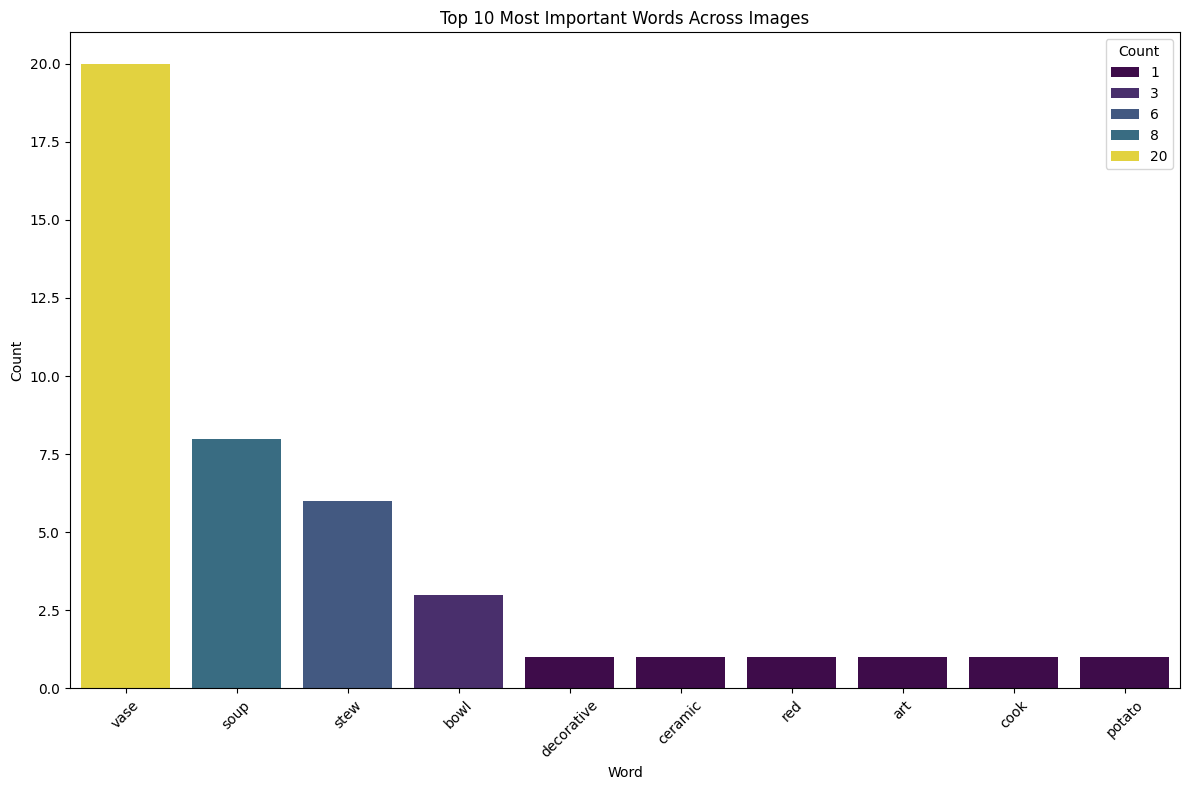

In [11]:
# Plot important words
plot_important_words(updated_dataset)

---

## 7. Compare AOPC Scores

Finally, we compare AOPC scores for SMER and LIME importance scores using the `plot_aopc` function.

Computing LIME importances: 100%|██████████| 9/9 [00:01<00:00,  5.15it/s]


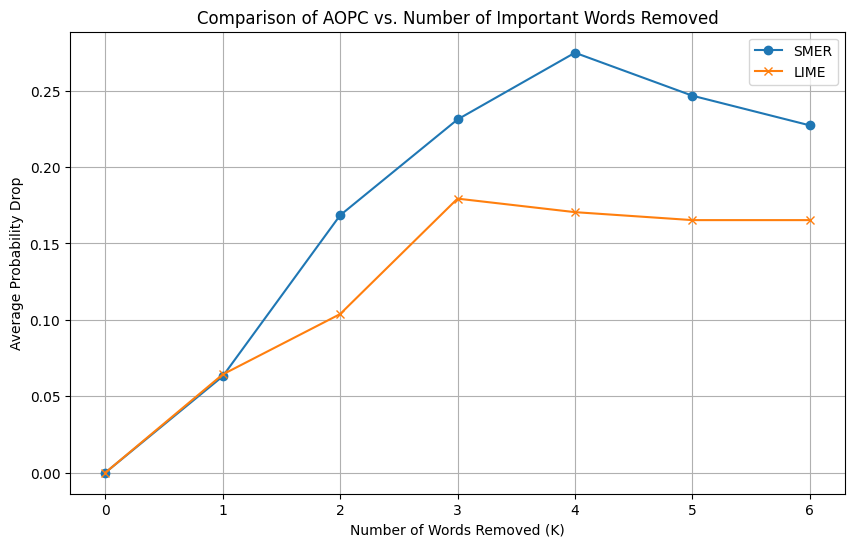

In [12]:
# Plot AOPC scores
plot_aopc(aopc_df, logreg_model, max_k=6)